# Notebook: Use NN to predict disease from chemicals using Opa2Vec vectors
<b> Author: </b> Ian Coleman <br>
<b> Purpose: </b> Take the vectors created in the opa2vec notebook. This took chemical go functions
    and disease go function, creating vectors for each. Train a NN to predict positive chem-dis relationships from these vectors

In [13]:
## TODO
# Hyperparameter tuning:
# 1. How many uncorrelated pairs do we want
# 2. Epochs
# 3. Batch size
# 4. Number of layers, number of nodes per layer
# 5. Activation functions

In [14]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from random import randint
import random
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from pandas_ml import ConfusionMatrix
import json
import subprocess
from correlade import correlade
import distcorr
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
import itertools

#Set random seed
np.random.seed(1606)

### 1. Import Vectors and Pre-Process them

In [15]:
# Import vec file
with open('../../opa2vec/outter.lst', 'r') as file:
    text = file.read()

In [16]:
# Strip and split vector data into list of lists [chem, vec]
text = text.replace('\n', '')
text = text.split(']')
text = [item.strip().split(' [') for item in text]

# Turn it into a data frame
df = pd.DataFrame(text)
df.columns = ['ID', 'Vector']

# Clean
df = df.dropna()
df['Vector'] = df.Vector.map(lambda x: x.rstrip().lstrip().replace('    ', ' ').replace('   ', ' ').replace('  ', ' ').replace(' ', ','))

# Turn vector column into a list
df['Vector'] = df.Vector.map(lambda x: x.split(','))

In [29]:
df.sample(13)

,ID,Vector,DirCorr,InvCorr,UnspecCorr
12475,D003980,"[-0.0200735, 0.03149306, 0.0478388, -0.0742555...",0,0,1
6922,D004040,"[0.01525462, 0.01701163, 0.12315422, -0.175103...",0,1,0
2948,C000591222,"[-7.52994046e-02, -4.74563017e-02, 6.89144954e...",1,0,0
2704,D002701,"[-0.01412567, -0.00416864, 0.09062478, -0.1331...",0,0,1
7255,D000068338,"[0.0384247, 0.04717167, 0.17144926, -0.1798658...",0,1,0
9251,C096128,"[-0.00306818, 0.06337161, 0.05014515, -0.09434...",0,0,1
1849,C020174,"[1.88992871e-03, 2.84740049e-02, 6.83972687e-0...",0,1,0
8872,C081294,"[-0.01151961, 0.06354568, 0.05427047, -0.08498...",0,1,0
1624,D002117,"[0.12155357, 0.07147935, 0.3645048, -0.3311547...",0,1,0
3330,C027373,"[0.02991511, 0.00092505, 0.14979436, -0.221528...",0,0,1


In [28]:
# Remove the -p /-n tags (pos/neg correlation) and add them as columns
df['DirCorr'] = df.ID.map(lambda x: 1 if '-p' in x else 0)
df['InvCorr'] = df.ID.map(lambda x: 1 if '-n' in x else 0)
df['UnspecCorr'] = df.DirCorr + df.InvCorr
df['UnspecCorr'] = df.UnspecCorr.map(lambda x: 0 if x == 1 else 1)

df['ID'] = df.ID.apply(lambda x: x.replace('-p', '').replace('-n', ''))

In [18]:
df.ID.nunique()

12747

### 2. Create DF for NN
Munge the df into the following columns:<br>
ChemID DisID ChemVec DisVec PositiveAssociationExists(binary)

In [19]:
# Step 1: Import file of proven chem-dis positive associations (created in ctd-to-nt notebook from ctd data)
chem_dis = pd.read_csv('../ctd-to-nt/chem-dis-pos-assocs.csv')
chem_dis.head()

,ChemicalID,DiseaseID,DirectEvidence
0,C046983,MESH:D054198,therapeutic
1,C112297,MESH:D006948,marker/mechanism
2,C112297,MESH:D012640,marker/mechanism
3,C039775,MESH:D004827,therapeutic
4,C425777,MESH:D006948,marker/mechanism


In [20]:
chem_dis.DiseaseID.nunique()

3191

In [21]:
chem_dis.shape

(96086, 3)

In [30]:
# Get rid of any chems/diseases that don't have a vector
chem_dis['DiseaseID'] = chem_dis['DiseaseID'].astype(str)
df['ID'] = df['ID'].astype(str)
id_list = df.ID.tolist() # list of chems+diseases with vecs

# chem_dis['DiseaseID'] = chem_dis['DiseaseID'].str.replace('MESH:', '')
# chem_dis['DiseaseID'] = chem_dis['DiseaseID'].str.replace('OMIM:', '')

chem_dis['hasDVec'] = chem_dis.DiseaseID.map(lambda x: x in id_list)
chem_dis['hasCVec'] = chem_dis.ChemicalID.map(lambda x: x in id_list)
chem_dis = chem_dis.loc[(chem_dis['hasDVec'] == True) & (chem_dis['hasCVec'] == True)]
chem_dis = chem_dis.drop(['hasDVec','hasCVec'], axis=1)

In [31]:
id_list[:4]

['MESH:D058186', 'MESH:D018248', 'MESH:C566304', 'MESH:D000544']

In [32]:
len(id_list)

12747

In [33]:
# merge all info into one df
# this df now contains only correlated diseases and vecs
df_d = df.copy()
df_d.columns= ['DiseaseID', 'DVec', 'disDirCorr', 'disInvCorr', 'disUnspecCorr']
df_c = df.copy()
df_c.columns= ['ChemicalID', 'CVec', 'chemDirCorr', 'chemInvCorr', 'chemUnspecCorr']
df1 = pd.merge(chem_dis, df_d, on='DiseaseID')
df1 = pd.merge(df1, df_c, on='ChemicalID')

# df1['Correlation'] = 1 # currently only have correlated in there

In [14]:
# df1['Correlation'] = df1.DirectEvidence.map(lambda x: 0 if x == 'therapeutic' else 2)

In [15]:
# df1[['DirectEvidence']] = df1[['DirectEvidence']].fillna(value='Uncorrelated')
# df1.DirectEvidence.value_counts()

marker/mechanism    6660
therapeutic         3376
Name: DirectEvidence, dtype: int64

In [16]:
# df1['target'] = df1.DirectEvidence.astype('category').cat.codes

In [34]:
df1.head()

,ChemicalID,DiseaseID,DirectEvidence,DVec,DirCorr_x,InvCorr_x,UnspecCorr_x,CVec,DirCorr_y,InvCorr_y,UnspecCorr_y
0,C039775,MESH:D004827,therapeutic,"[0.03703349, 0.01702639, 0.16707323, -0.230416...",1,0,0,"[-0.00631367, 0.05053534, 0.05186689, -0.07342...",0,0,1
1,C039775,MESH:D004827,therapeutic,"[-0.01980298, -0.0501533, 0.08079536, -0.10425...",0,0,1,"[-0.00631367, 0.05053534, 0.05186689, -0.07342...",0,0,1
2,D000086,MESH:D004827,therapeutic,"[0.03703349, 0.01702639, 0.16707323, -0.230416...",1,0,0,"[-0.01689105, 0.0316028, 0.03639323, -0.125525...",1,0,0
3,D000086,MESH:D004827,therapeutic,"[0.03703349, 0.01702639, 0.16707323, -0.230416...",1,0,0,"[-0.01365298, 0.05250643, 0.04785401, -0.07331...",0,1,0
4,D000086,MESH:D004827,therapeutic,"[-0.01980298, -0.0501533, 0.08079536, -0.10425...",0,0,1,"[-0.01689105, 0.0316028, 0.03639323, -0.125525...",1,0,0


In [18]:
df1.target.unique()

array([0, 1])

In [19]:
# Create separate dfs of dis-vecs and chem-vecs ( in order to generate additional rows for df1)
dis = df.ID.map(lambda x: ('MESH' in x) | ('OMIM' in x))
chems = df.ID.map(lambda x: ('MESH' not in x) & ('OMIM' not in x))

df_chems = df[chems]
df_dis = df[dis]
df_chems = df_chems.reset_index(drop=True)
df_dis = df_dis.reset_index(drop=True)

In [20]:
# Add unrelated pairs to df1
no_rows = (df1.shape[0]-1)  # This is a parameter to be tuned --> how many uncorrelated pairs do we want
print('shape: ', no_rows)

# Randomly select chems and diseases (as many as there are related pairs)
no_chems = len(df_chems) -1
no_dis = len(df_dis) -1
rand_chems = np.random.choice(no_chems, no_rows, replace=True)
# np.random.seed(1606)
rand_dis = np.random.choice(no_dis, no_rows, replace=True)

# Add the new pairs as rows
for x in range(0, no_rows):
    int1 = rand_chems[x]
    int2 = rand_dis[x]
    chem, chemvec = df_chems.loc[int1, 'ID'], df_chems.loc[int1, 'Vector']
    dis, disvec = df_dis.loc[int2, 'ID'], df_dis.loc[int2, 'Vector']
    df1 = df1.append({'ChemicalID':chem, 'DiseaseID':dis, 'CVec':chemvec, 'DVec':disvec, 'Correlation':1}, ignore_index=True)

print(df1.shape)
# Drop any duplicates (removes known correlated pairs accidentally generated as uncorrelated)
df1 = df1.drop_duplicates(subset=['ChemicalID', 'DiseaseID'], keep=False)
print(df1.shape)

shape:  10035
(20071, 7)
(18508, 7)


In [21]:
# Convert the elements of the vectors to actual numbers
df1['DVec'] = df1.DVec.map(lambda x: [float(i) for i in x])
df1['CVec'] = df1.CVec.map(lambda x: [float(i) for i in x])

In [22]:
# Turn correlation into three options
# [1,0,0] --> neg corr
# [0,1,0] --> no corr
# [0,0,1] --> pos corr
# Note we can't be certain that the unrelated pairs are actually unrelated

df1['y'] = df1.Correlation.map(lambda x: [1,0,0] if x == 0 else ([0,1,0] if x == 1 else [0,0,1]))

In [23]:
# # Chopping out negatively correlated in order to test the new vectors as compared to original setup
# print(df1.shape)
# df1 = df1[df1.Correlation != 0]
# print(df1.shape)
# df1.Correlation = df1.Correlation.map(lambda x: x-1)

In [24]:
df1.Correlation.value_counts()

1    9832
2    5966
0    2710
Name: Correlation, dtype: int64

### 2. Preprocess
Now that we have the df ready, let's split it into train/test/validation sets and convert it into numpy arrays so it can be consumed by a Keras NN

In [25]:
print(len(df1[df1.DirectEvidence =='marker/mechanism']))
print(len(df1[df1.DirectEvidence =='therapeutic']))
print(len(df1[df1.DirectEvidence.isna()]))

5966
2710
9832


In [26]:
df1.head()

,ChemicalID,DiseaseID,DirectEvidence,DVec,CVec,Correlation,target,y
0,C049584,MESH:D001943,marker/mechanism,"[-0.14895332, -0.01025543, -0.25262636, -0.051...","[-0.000117902062, 0.111350939, 0.0451662578, -...",2,0.0,"[0, 0, 1]"
1,C049584,MESH:D018270,marker/mechanism,"[0.01758267, 0.12877887, 0.04066193, -0.121200...","[-0.000117902062, 0.111350939, 0.0451662578, -...",2,0.0,"[0, 0, 1]"
2,C049584,MESH:D019457,marker/mechanism,"[-0.00141219131, 0.125337347, 0.0641415045, -0...","[-0.000117902062, 0.111350939, 0.0451662578, -...",2,0.0,"[0, 0, 1]"
3,C049584,MESH:D003110,marker/mechanism,"[-0.0604746304, 0.123549119, -0.0685045198, -0...","[-0.000117902062, 0.111350939, 0.0451662578, -...",2,0.0,"[0, 0, 1]"
4,C049584,MESH:D015179,marker/mechanism,"[-0.11238139, 0.02963986, -0.21585341, -0.0767...","[-0.000117902062, 0.111350939, 0.0451662578, -...",2,0.0,"[0, 0, 1]"


In [27]:
# For Keras, need to turn inputs into numpy arrays instead of pandas df
# First create single np array of the two vectors CONCERN: should these be two separate inputs?
Dvecs = pd.DataFrame(df1.DVec.values.tolist(), index= df1.index)
Cvecs = pd.DataFrame(df1.CVec.values.tolist(), index= df1.index)
all_X = Dvecs.merge(Cvecs, how='outer', left_index=True, right_index=True)
all_X = np.array(all_X)

In [28]:
df1.sample(1)

,ChemicalID,DiseaseID,DirectEvidence,DVec,CVec,Correlation,target,y
8345,D014635,MESH:D007021,marker/mechanism,"[0.01703165, 0.14660516, 0.05962492, -0.118774...","[-0.18718341, -0.05902867, -1.2147478, -0.0168...",2,0.0,"[0, 0, 1]"


In [29]:
df1.y = df1.y.map(lambda x: np.array(x))

In [54]:
# Now create np array of the y output
# all_y = np.array(df1.y)
all_y = np.array(df1.y)

In [55]:
# Here I'm going to split y into three columns, model isn't accepting the current col of lists
df1[['neg_corr', 'no_corr', 'pos_corr']] = pd.DataFrame(df1.y.values.tolist(), index= df1.index)
# Turn those three columns into a numpy matrix for y
all_y = df1[['neg_corr', 'no_corr', 'pos_corr']].values

In [56]:
print('y shape: ', all_y.shape)
print('X shape: ', all_X.shape)

y shape:  (18508, 3)
X shape:  (18508, 400)


In [57]:
# # Create training, test, val set in a way that we can later look at the rows of each BY ROWS
# total_rows = len(all_X)
# row_numbers = list(range(0, total_rows))

# training_rows = random.sample(row_numbers, int(round(total_rows * .6)))
# row_numbers = set(row_numbers) - set(training_rows)

# test_rows = random.sample(row_numbers, int(round(total_rows * .2)))
# row_numbers = set(row_numbers) - set(test_rows)

# val_rows = list(row_numbers)

In [58]:
# Split into train, test, val BY CHEMICAL instead of by random rows
print('number of chemicals: ', len(df1.ChemicalID.unique()))
print('number of dis: ', len(df1.DiseaseID.unique()))
chems = list(df1.ChemicalID.unique())
random.shuffle(chems)

total_chems = len(chems)
train_chems = chems[:round(total_chems * .6)]
test_chems = chems[round(total_chems * .6):round(total_chems * .8)]
val_chems = chems[round(total_chems * .8):]

print(len(train_chems), len(test_chems), len(val_chems))

# Now get the row numbers for each set of chemicals 

number of chemicals:  412
number of dis:  2514
247 83 82


In [59]:
df1['train'] = df1.ChemicalID.isin(train_chems)
df1['test'] = df1.ChemicalID.isin(test_chems)
df1['val'] = df1.ChemicalID.isin(val_chems)

In [60]:
df1 = df1.reset_index()
training_rows = df1.index[df1.train == True].tolist()
test_rows = df1.index[df1.test == True].tolist()
val_rows = df1.index[df1.val == True].tolist()

In [61]:
# Split into train, test, val
X_train, X_test, X_val = all_X[training_rows], all_X[test_rows], all_X[val_rows]
y_train, y_test, y_val = all_y[training_rows], all_y[test_rows], all_y[val_rows]

print(len(training_rows), len(test_rows), len(val_rows))

11151 3580 3777


In [62]:
# # Split into train, test, val --> OLD WAY
# X_train, X_test, y_train, y_test = train_test_split(all_X, all_y, test_size=0.2, random_state=1606)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1606)

In [68]:
y_train.shape

(11151, 3)

In [64]:
X_train.shape

(11151, 400)

In [65]:
# X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
# X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [66]:
X_train.shape

(11151, 400)

### 3. Establish NN Model

In [69]:
# 1. Establish the model architecture
#it's safe to say that I don't know what I'm doing here
model = keras.Sequential([
#     keras.layers.Dense(400, activation=tf.nn.relu), 
    keras.layers.Dense(200,  input_dim=400, activation=tf.nn.relu),
    keras.layers.Flatten(), 
#     tf.layers.flatten(inputs),
#     keras.layers.Dropout(rate=0.2, noise_shape=None, seed=None),
    keras.layers.Dense(10, activation=tf.nn.relu),
#     keras.layers.Dropout(rate=0.2, noise_shape=None, seed=None),
    keras.layers.Flatten(), 
    keras.layers.Dense(3, activation=tf.nn.softmax)
])

In [305]:
# ## This is the old model, purely for comparing new vectors to old

# # 1. Establish the model architecture
# #it's safe to say that I don't know what I'm doing here
# model = keras.Sequential([
# #     keras.layers.Dense(400, activation=tf.nn.relu), 
#     keras.layers.Dense(200, activation=tf.nn.relu),
#     keras.layers.Dropout(rate=0.2, noise_shape=None, seed=None),
#     keras.layers.Dense(10, activation=tf.nn.relu),
#     keras.layers.Dropout(rate=0.2, noise_shape=None, seed=None),
#     keras.layers.Dense(1, activation=tf.nn.sigmoid)
# ])

# # 2. Compile the model (give it loss func, optimise func and eval metric)
# model.compile(optimizer=tf.train.AdamOptimizer(), # determines how the model is adapted based on loss func
#               loss='binary_crossentropy', # measure of accuracy during training
#               metrics=['accuracy']) # measure for train and testing steps

# # 3. Train
# model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val) ) #, callbacks=[earlystop])

In [ ]:
## Alt model attempt

# data_dim = 400
# timesteps = 1
# num_classes = 3

# model = keras.Sequential()
# model.add(keras.layers.LSTM(30, return_sequences=True,
#                input_shape=(timesteps, data_dim)))  # returns a sequence of vectors of dimension 30
# model.add(keras.layers.LSTM(30, return_sequences=True))  # returns a sequence of vectors of dimension 30
# model.add(keras.layers.LSTM(30))  # return a single vector of dimension 30
# model.add(keras.layers.Dense(3, activation='softmax'))

# model.compile(loss='sparse_categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

# model.summary()
# model.fit(X_train, y_train, batch_size = 400, epochs = 10, verbose = 1)

In [70]:
# 2. Compile the model (give it loss func, optimise func and eval metric)
model.compile(optimizer=tf.train.AdamOptimizer(), # determines how the model is adapted based on loss func
              loss='categorical_crossentropy', # measure of accuracy during training
              metrics=['accuracy']) # measure for train and testing steps 

In [71]:
# Pre-training, set up training params
# earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None)

In [72]:
# 3. Train
model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val) ) #, callbacks=[earlystop])

Train on 11151 samples, validate on 3777 samples
Epoch 1/10
11151/11151 [==============================] - 1s 97us/step - loss: 0.8304 - acc: 0.6436 - val_loss: 0.8281 - val_acc: 0.6420
Epoch 2/10
11151/11151 [==============================] - 1s 80us/step - loss: 0.7786 - acc: 0.6679 - val_loss: 0.8473 - val_acc: 0.6227
Epoch 3/10
11151/11151 [==============================] - 1s 84us/step - loss: 0.7597 - acc: 0.6772 - val_loss: 0.8209 - val_acc: 0.6574
Epoch 4/10
11151/11151 [==============================] - 1s 83us/step - loss: 0.7523 - acc: 0.6820 - val_loss: 0.8419 - val_acc: 0.6537
Epoch 5/10
11151/11151 [==============================] - 1s 80us/step - loss: 0.7332 - acc: 0.6915 - val_loss: 0.9111 - val_acc: 0.6420
Epoch 6/10
11151/11151 [==============================] - 1s 83us/step - loss: 0.7258 - acc: 0.6931 - val_loss: 0.8316 - val_acc: 0.6553
Epoch 7/10
11151/11151 [==============================] - 1s 83us/step - loss: 0.7133 - acc: 0.7009 - val_loss: 0.8347 - val_acc:

### ...and evaluate

In [73]:
# 4. Evaluate
# Accuracy
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

3580/3580 [==============================] - 0s 43us/step
Test accuracy: 0.6452513965814474


In [74]:
# Get actual predictions for test set
predictions = model.predict(X_test)
rounded_predictions = [int(float(round(x[0]))) for x in predictions]

In [97]:
# %matplotlib inline
# # Confusion Matrix for binary classificaiton

# confusion_matrix = ConfusionMatrix(y_test, rounded_predictions)
# print("Confusion matrix:\n%s" % confusion_matrix)
# confusion_matrix.plot()

Confusion matrix, without normalization
[[ 166  187  111]
 [  71 1810  114]
 [ 260  527  334]]


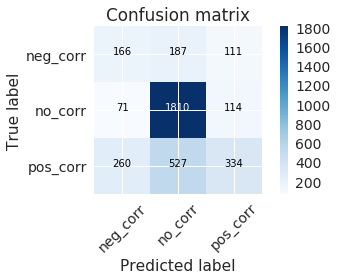

In [99]:
# Plot multiclass confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    

matrix = sklearn.metrics.confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
plot_confusion_matrix(matrix, ['neg_corr', 'no_corr', 'pos_corr'])

In [76]:
# ROC AUC
print('ROC AUC: ', roc_auc_score(y_test, predictions))

ROC AUC:  0.7683330246160643


### 4. Examine the predictions
Let's look at the predictions the NN gets wrong, see if there's a pattern

In [ ]:
# Create df with the relevant data
test_set = df1.loc[test_rows]
test_set['Predictions'] = predictions
test_set['RoundPredictions'] = rounded_predictions

In [ ]:
# Optimise memory --> set col types for the incoming CSV
cds_cols = ['# ChemicalName', 'ChemicalID', 'DiseaseName', 'DiseaseID', 'DirectEvidence']
cd_col_types = {   
    '# ChemicalName': 'category',
    'ChemicalID': 'category',
    'DiseaseName': 'category',
    'DiseaseID': 'category',
}

In [ ]:
# Let's get the disease and chemical names back! For the sake of eyeballing for patterns
# Read in CTD csv, skipping the intro rows
df_cd = pd.read_csv('../ctd-to-nt/csvs/CTD_chemicals_diseases.csv', usecols=cds_cols, dtype=cd_col_types, skiprows=27)
df_cd = df_cd.drop(0)
df_cd = df_cd.dropna(subset=['DirectEvidence']) # drop if it doesn't have direct evidence

In [ ]:
df_cd.head()

In [ ]:
test_set.head()

In [ ]:
# Get ready for some memory-optimisation
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)

In [ ]:
test_set['Correlation'] = test_set.Correlation.astype(np.uint8)
print(mem_usage(test_set['RoundPredictions']))
test_set['RoundPredictions'] = test_set.RoundPredictions.astype(np.uint8)
print(mem_usage(test_set['RoundPredictions']))

In [ ]:
# merge in the names

# Because this weirdly requires a tonne of memory, let's optimise (for stupid terrible top-of-range dell laptop)
lst = [chem_dis, df, df_d, df_c, Dvecs, Cvecs]
del lst
test_set = test_set.drop(['DVec', 'CVec', 'index'], axis=1) # these cols are memory intensive
df_cd.ChemicalID = df_cd.ChemicalID.astype('category')
for col in ['DiseaseID', 'ChemicalID', 'DiseaseName', '# ChemicalName', 'DirectEvidence']:
    if str(col) in df_cd.columns: df_cd[col] = df_cd[col].astype('category')
    if col in test_set.columns: test_set[col] = test_set[col].astype('category')
        
test_set = pd.merge(test_set, df_cd[['DiseaseID', 'DiseaseName']], on='DiseaseID')
test_set = pd.merge(test_set, df_cd[['# ChemicalName', 'ChemicalID']], on='ChemicalID')

# weirdly these operations introduce millions of duplicate rows, so delete duplicates:
test_set = test_set.drop_duplicates(list(set(test_set.columns.values))) #- set(['DVec','CVec'])))

In [ ]:
# Import gofunction counts (for each disease and each chem). This csv was output in opa2vec.ipynb
gofunc_counts = pd.read_csv('gofunc_counts.csv')
test_set = pd.merge(test_set, gofunc_counts[['ChemicalID', 'gofunc']], on='ChemicalID')
test_set = test_set.rename(columns = {'gofunc':'ChemGoFuncs'})
test_set = pd.merge(test_set, gofunc_counts[['DiseaseID', 'gofunc']], on='DiseaseID')
test_set = test_set.rename(columns = {'gofunc':'DisGoFuncs'})

# Create combined gofunc count col
test_set['sumGoFuncs'] = test_set.ChemGoFuncs + test_set.DisGoFuncs
test_set['prodGoFuncs'] = test_set.ChemGoFuncs * test_set.DisGoFuncs



In [ ]:
# Create false pos and false neg col
test_set['false_pos'] = abs(test_set.RoundPredictions - test_set.Correlation).map(lambda x: 0 if x > 200 else x)
test_set['true_pos'] = (test_set.RoundPredictions + test_set.Correlation).map(lambda x: 1 if x==2 else 0)

In [ ]:
test_set.sample(13)

In [ ]:
# v=np.linspace(-1,1,10001)
# print (np.corrcoef(v,np.abs(v))[0,1], distcorr.distcorr(v,np.abs(v)))

In [ ]:
# Test data for distance correlation
data = [[4,10],[4,12],[6,13]]
zdf = pd.DataFrame(data,columns=['Name','Age'],dtype=np.int64)
type(zdf.Name[1])

In [ ]:
# correlade.dcorr(zdf)
zdf.head().corr()

In [ ]:
#Distance Correlation
correlade.dcorr(test_set.sample(1300)[['Correlation', 'Predictions', 'RoundPredictions', 'ChemGoFuncs', 'DisGoFuncs', 'sumGoFuncs', 'prodGoFuncs', 'false_pos']])

In [ ]:
#Pearson Correlation
test_set[['Correlation', 'Predictions', 'RoundPredictions', 'ChemGoFuncs', 'DisGoFuncs', 'sumGoFuncs', 'prodGoFuncs', 'false_pos']].corr()

In [ ]:
#Pearson Correlation
test_set[['Correlation', 'Predictions', 'RoundPredictions', 'ChemGoFuncs', 'DisGoFuncs', 'sumGoFuncs', 'prodGoFuncs', 'false_pos']].corr(method='spearman')

In [ ]:
test_set[['DiseaseName', '# ChemicalName', 'Correlation', 'Predictions', 'RoundPredictions', 'ChemGoFuncs', 'DisGoFuncs', 'false_pos']].to_csv('predictions.csv', index=False)

In [ ]:
# # This cell is pointless - manually verifying accuracy test
# # Round predictions to int based on threshold, run accuracy-test manually
# predictions = model.predict(X_test)
# threshold = predictions[:].sum()/len(predictions) # Threshold is the mean value of predictions
# predictions = [float(round(x[0]-threshold+0.5)) for x in predictions]
# manual_accuracy = sklearn.metrics.accuracy_score(y_test, predictions, normalize=True, sample_weight=None)
# print(manual_accuracy)

### 5. Calculate Cosine Similary

In [ ]:
# df1.head()

In [ ]:
# Calculate out the cosine similarity and see if there's a difference between groups
def cosine_sim (row):
    return cosine_similarity(np.array(row.DVec).reshape(1, -1), np.array(row.CVec).reshape(1, -1))[0][0]

df1['cosine_sim'] = df1.apply(lambda row: cosine_sim(row), axis=1)

# Compare cosine sim of correlated and uncorrelated groups
print('Cosine mean with no correlation: ', df1[df1.Correlation == 1 ].cosine_sim.mean())
print('Cosine mean with correlation: ', df1[df1.Correlation == 0 ].cosine_sim.mean())

### 6. Save Model

In [ ]:
# # Save model (in two files, one for weights and one for json)
# json_string = model.to_json()
# model.save_weights("model2-0.82.h5")
# with open('model2-0.82.json', 'w') as outfile:
#     json.dump(json_string, outfile)